<a href="https://colab.research.google.com/github/WHARN0/Pengolahan-Citra-dan-Visi-Komputer/blob/main/PROJECT_PCVK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Install Libraries**

In [ ]:
!pip install tensorflow opencv-python-headless matplotlib scikit-learn pandas kagglehub

# **Import Libraries**

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import cv2
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# **Download and Move Dataset to Local**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bagusarnovario","key":"a1cd1870fcd8f8aa05dceed8e5513e49"}'}

In [ ]:
import os
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("Kaggle API Key configured!")

Kaggle API Key configured!


In [ ]:
# Download dataset from Kaggle
!kaggle datasets download -d niten19/face-shape-dataset

# Unzip the dataset
!unzip face-shape-dataset.zip -d /content/FaceShape_Dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/FaceShape_Dataset/FaceShape Dataset/testing_set/Heart/heart (123).jpg  
  inflating: /content/FaceShape_Dataset/FaceShape Dataset/testing_set/Heart/heart (13).jpg  
  inflating: /content/FaceShape_Dataset/FaceShape Dataset/testing_set/Heart/heart (135).jpg  
  inflating: /content/FaceShape_Dataset/FaceShape Dataset/testing_set/Heart/heart (136).jpg  
  inflating: /content/FaceShape_Dataset/FaceShape Dataset/testing_set/Heart/heart (137).jpg  
  inflating: /content/FaceShape_Dataset/FaceShape Dataset/testing_set/Heart/heart (138).jpg  
  inflating: /content/FaceShape_Dataset/FaceShape Dataset/testing_set/Heart/heart (139).jpg  
  inflating: /content/FaceShape_Dataset/FaceShape Dataset/testing_set/Heart/heart (140).jpg  
  inflating: /content/FaceShape_Dataset/FaceShape Dataset/testing_set/Heart/heart (141).jpg  
  inflating: /content/FaceShape_Dataset/FaceShape Dataset/testing_set/Heart/heart (156).jpg  
  inflatin

In [ ]:
# Move dataset to Google Drive
!mv /content/FaceShape_Dataset /content/drive/MyDrive/PCVK_MM
print("Dataset berhasil dipindahkan ke Google Drive!")

mv: inter-device move failed: '/content/FaceShape_Dataset' to '/content/drive/MyDrive/PCVK_MM/FaceShape_Dataset'; unable to remove target: Directory not empty
Dataset berhasil dipindahkan ke Google Drive!


In [ ]:
dataset_path = '/content/drive/MyDrive/PCVK_MM/FaceShape_Dataset/FaceShape-Dataset'
print("Dataset path sudah siap!")

Dataset path sudah siap!


# **Preprocessing Dataset**

In [ ]:
def prepare_dataset(data_dir, subset='training_set'):
    images = []
    labels = []
    label_map = {
        'Oval': 0,
        'Round': 1,
        'Square': 2,
    }

    data_dir = os.path.join(data_dir, subset)

    for shape in label_map.keys():
        shape_dir = os.path.join(data_dir, shape)
        if os.path.exists(shape_dir):
            print(f"Processing {shape} images...")
            for img_name in os.listdir(shape_dir):
                if img_name.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(shape_dir, img_name)
                    try:
                        img = load_img(img_path, target_size=(128, 128))
                        img_array = img_to_array(img) / 255.0
                        images.append(img_array)
                        labels.append(label_map[shape])
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")

    print(f"Total images processed: {len(images)}")
    for shape, idx in label_map.items():
        count = labels.count(idx)
        print(f"{shape}: {count} images")

    images, labels = np.array(images), np.array(labels)

    # Shuffle the dataset
    indices = np.arange(len(images))
    np.random.shuffle(indices)
    images = images[indices]
    labels = labels[indices]

    data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

    return images, labels

X_train, y_train = prepare_dataset(dataset_path, 'training_set')
X_test, y_test = prepare_dataset(dataset_path, 'testing_set')

Processing Oval images...
Processing Round images...
Processing Square images...
Error loading image /content/drive/MyDrive/PCVK_MM/FaceShape_Dataset/FaceShape-Dataset/training_set/Square/square (84).jpg: image file is truncated (0 bytes not processed)
Total images processed: 2398
Oval: 800 images
Round: 800 images
Square: 798 images
Processing Oval images...


# **Build Model**

In [ ]:
def create_model(input_shape=(128, 128, 3), num_classes=3):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize the model
model = create_model()

# **Train Model**

In [ ]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('best_face_shape_model.keras', save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
    ]
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks
    )
    return history

# Train the model
history = train_model(model, X_train, y_train, X_test, y_test)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.3499 - loss: 1.8579 - val_accuracy: 0.3500 - val_loss: 1.3451 - learning_rate: 1.0000e-04
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4694 - loss: 1.0578 - val_accuracy: 0.3800 - val_loss: 1.1699 - learning_rate: 1.0000e-04
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5000 - loss: 0.9911 - val_accuracy: 0.4350 - val_loss: 1.0830 - learning_rate: 1.0000e-04
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5475 - loss: 0.9513 - val_accuracy: 0.4050 - val_loss: 1.3085 - learning_rate: 1.0000e-04
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5705 - loss: 0.8904 - val_accuracy: 0.4683 - val_loss: 1.1865 - learning_rate: 1.0000e-04
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5750 - loss: 0.8827 - val_accuracy: 0.4500 - val_loss: 1.1955 - learning_rate: 1.0000e-04
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.630

# **Visualization**

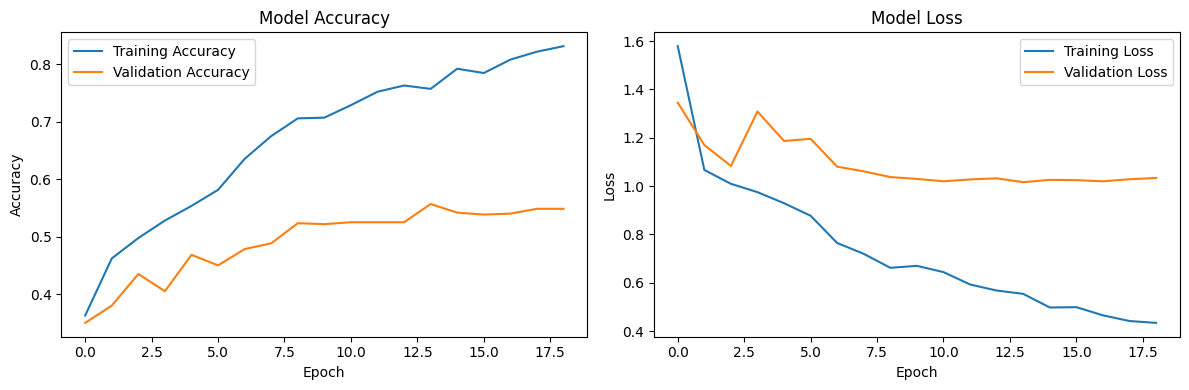

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

# **Save Model**

In [ ]:
model_path = '/content/drive/MyDrive/PCVK_MM/face_shape_classifier_final.keras'
model.save(model_path)
print(f"Model berhasil disimpan di: {model_path}")

Model berhasil disimpan di: /content/drive/MyDrive/PCVK_MM/face_shape_classifier_final.keras


# **Load Model**

In [ ]:
from tensorflow.keras.models import load_model
model_path = '/content/drive/MyDrive/PCVK_MM/face_shape_classifier_final.keras'
model = load_model(model_path)
print("Model berhasil dimuat dari Google Drive!")

Model berhasil dimuat dari Google Drive!


# **Classification**

Model berhasil dimuat dari Google Drive!


Saving round (3).jpg to round (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


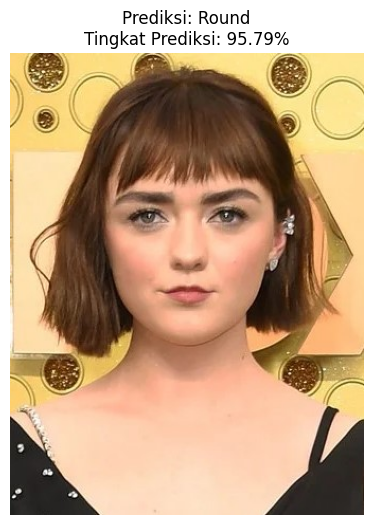

In [ ]:
# Load pre-trained model from Google Drive
from tensorflow.keras.models import load_model
model_path = '/content/drive/MyDrive/PCVK_MM/face_shape_classifier_final.keras'  # Path model di Google Drive
model = load_model(model_path)
print("Model berhasil dimuat dari Google Drive!")

# Define the classify function
def classify_face_shape(image_path, model):
    """Classify a single image with enhanced output"""
    from tensorflow.keras.utils import load_img, img_to_array
    import matplotlib.pyplot as plt
    import numpy as np

    # Load and preprocess image
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)

    # Predict using the model
    prediction = model.predict(img_array)
    label_map = ['Oval', 'Round', 'Square']  # Ensure this matches your training labels
    max_prob = np.max(prediction)  # Highest confidence value
    max_index = np.argmax(prediction)  # Index of highest confidence value

    # Determine the predicted label or fallback if confidence < 50%
    if max_prob >= 0.5:  # If confidence is at least 50%
        predicted_shape = label_map[max_index]
    else:
        predicted_shape = "Bukan round, oval, ataupun square"

    # Display result
    plt.figure(figsize=(6, 6))
    plt.imshow(load_img(image_path))  # Show the uploaded image
    plt.title(f'Prediksi: {predicted_shape}\nTingkat Prediksi: {max_prob * 100:.2f}%')
    plt.axis('off')
    plt.show()

    return predicted_shape, max_prob * 100  # Confidence as percentage


# Upload and classify images
from google.colab import files
uploaded = files.upload()

for img_path in uploaded.keys():
    predicted_shape, confidence = classify_face_shape(img_path, model)

Saving square (5).jpg to square (5).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


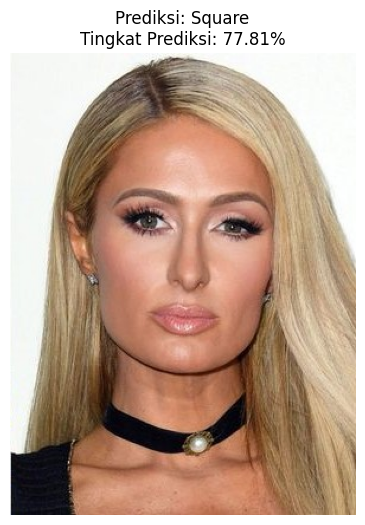

In [ ]:
# Upload and classify images
from google.colab import files
uploaded = files.upload()

for img_path in uploaded.keys():
    predicted_shape, confidence = classify_face_shape(img_path, model)

Saving oval (32).jpg to oval (32).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


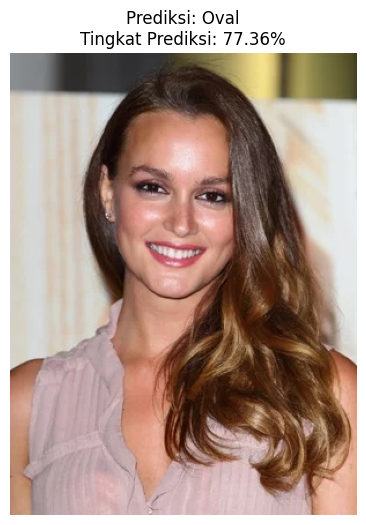

In [ ]:
# Upload and classify images
from google.colab import files
uploaded = files.upload()

for img_path in uploaded.keys():
    predicted_shape, confidence = classify_face_shape(img_path, model)

Saving oblong (13).jpg to oblong (13).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


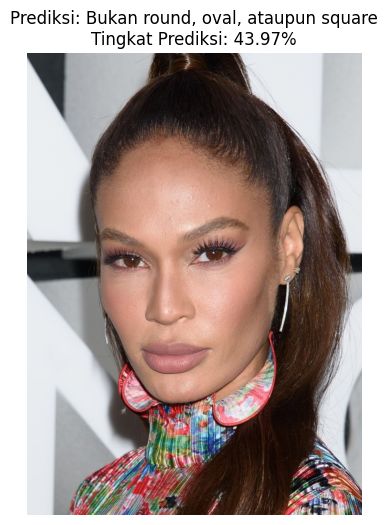

In [ ]:
# Upload and classify images
from google.colab import files
uploaded = files.upload()

for img_path in uploaded.keys():
    predicted_shape, confidence = classify_face_shape(img_path, model)